# K-Anonymity 
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>


In [1]:
import pandas as pd
from collections import Counter
from openpyxl import Workbook
table_name = "marketing_case_v.0.5.3.xlsx"
df = pd.read_excel(table_name, sheet_name="A2", engine = 'openpyxl')
df.tail(10)


,Микросегмент,Локальное время покупок,Широта,Долгота,Общая сумма покупок,Код региона,Часовой пояс,Кол-во покупок,Кол-во товаров в покупоке,Бренды,Категория
499990,91611940xx,2022-01-09,29.421,59.623,6556,38,UTC+5,4,4,Gamemax,Блоки питания
499991,91611379xx,2022-01-18,29.421,59.620,182058,38,UTC+5,6,6,RME,Звуковые карты
499992,91611232xx,2022-01-11,29.420,59.621,36741,38,UTC+5,3,3,Dell,Жесткие диски
499993,91611583xx,2022-01-30,29.426,59.639,606771,38,UTC+5,9,9,NEC,Монитор
499994,91611451xx,2022-01-28,29.421,59.615,145200,38,UTC+5,6,6,Iiyama,Монитор
499995,91611335xx,2022-01-07,29.421,59.620,14608440,38,UTC+5,7,7,Lenovo,Ноутбуки
499996,91611360xx,2022-01-11,29.426,59.607,36154,38,UTC+5,2,2,Iiyama,Монитор
499997,91611966xx,2022-01-27,29.424,59.624,21768,38,UTC+5,8,8,In Win,Корпуса
499998,91611148xx,2022-01-05,29.428,59.630,250716,38,UTC+5,3,3,BenQ,Монитор
499999,91611694xx,2022-01-02,29.421,59.616,30698,38,UTC+5,2,2,AOC,Монитор


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Микросегмент                500000 non-null  object 
 1   Локальное время покупок     500000 non-null  object 
 2   Широта                      500000 non-null  float64
 3   Долгота                     500000 non-null  float64
 4   Общая сумма покупок         500000 non-null  int64  
 5   Код региона                 500000 non-null  int64  
 6   Часовой пояс                500000 non-null  object 
 7   Кол-во покупок              500000 non-null  int64  
 8   Кол-во  товаров в покупоке  500000 non-null  int64  
 9   Бренды                      499766 non-null  object 
 10  Категория                   500000 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 42.0+ MB


Currently each row is unique

In [3]:
'Duplicates == ' + str(df.shape[0] - df.drop_duplicates().shape[0])

'Duplicates == 0'

#### Модель $k$-anonimity и риски повторной идентификации

<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p>


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>


In [4]:
QI = ['Микросегмент',
    'Локальное время покупок',
    'Общая сумма покупок',
    'Код региона',
    'Бренды',
    'Категория']


In [5]:
def k_anonymous(data, columns):
  ## Возьмите фрейм данных, верните значение k-anonymity
  ## Агрегируйте по именам столбцов и возьмите ненулевой минимум каждой строки
  aggregrate = data.groupby(columns).count().apply(lambda x : set(x) - set({0}),axis = 1)
  aggregrate = aggregrate.apply(lambda x : 0 if x == set() else min(x))
  count = dict(Counter(aggregrate))
  sort_arg = sorted(set(aggregrate))[:5]
  return [[arg,round(count[arg]/len(aggregrate) * 100,3)] for arg in sort_arg]
k_anonymous = k_anonymous(df, QI)
for arg in k_anonymous:
    print(f' k-anonymity = {arg[0]}[{arg[1]}%]')

 k-anonymity = 1[99.966%]
 k-anonymity = 2[0.034%]
 k-anonymity = 3[0.0%]


In [6]:
from decimal import localcontext, Decimal, ROUND_UP
def coefficient_nyu():
    df = pd.read_excel(table_name, sheet_name="B2", engine = 'openpyxl')
    df = df["Кол-во пользователей, просмотревших рекламу"].to_numpy()
    nyu = 0
    for arg in df:
        nyu+=arg
    with localcontext() as ctx:
        ctx.rounding = ROUND_UP
        nyu = Decimal(nyu/len(df))
        return int(nyu.to_integral_value())
k_anonymous_coefficient = [[arg[0] * coefficient_nyu(),arg[1]] for arg in k_anonymous]
for arg in k_anonymous_coefficient:    
    print(f'k-anonymity(coefficient) = {arg[0]}[{arg[1]}%]')

k-anonymity(coefficient) = 2[99.966%]
k-anonymity(coefficient) = 4[0.034%]
k-anonymity(coefficient) = 6[0.0%]


#### Количество уникальных строк

In [7]:
unique_rows = df[QI].drop_duplicates()
unique_rows.to_excel("uniques_row.xlsx")
print(f"Количество уникальных строк = {len(unique_rows)}")

Количество уникальных строк = 499828


In [8]:
print(unique_rows)

       Микросегмент Локальное время покупок  Общая сумма покупок  Код региона  \
0        91611574xx              2022-01-23               406134           38   
1        91611870xx              2022-01-28                73869           38   
2        91611395xx              2022-01-14                32032           38   
3        91611534xx              2022-01-06               312840           38   
4        91611261xx              2022-01-06                22072           38   
...             ...                     ...                  ...          ...   
499995   91611335xx              2022-01-07             14608440           38   
499996   91611360xx              2022-01-11                36154           38   
499997   91611966xx              2022-01-27                21768           38   
499998   91611148xx              2022-01-05               250716           38   
499999   91611694xx              2022-01-02                30698           38   

        Бренды Категория  


#### Графики подсчета этих типов данных показаны ниже.

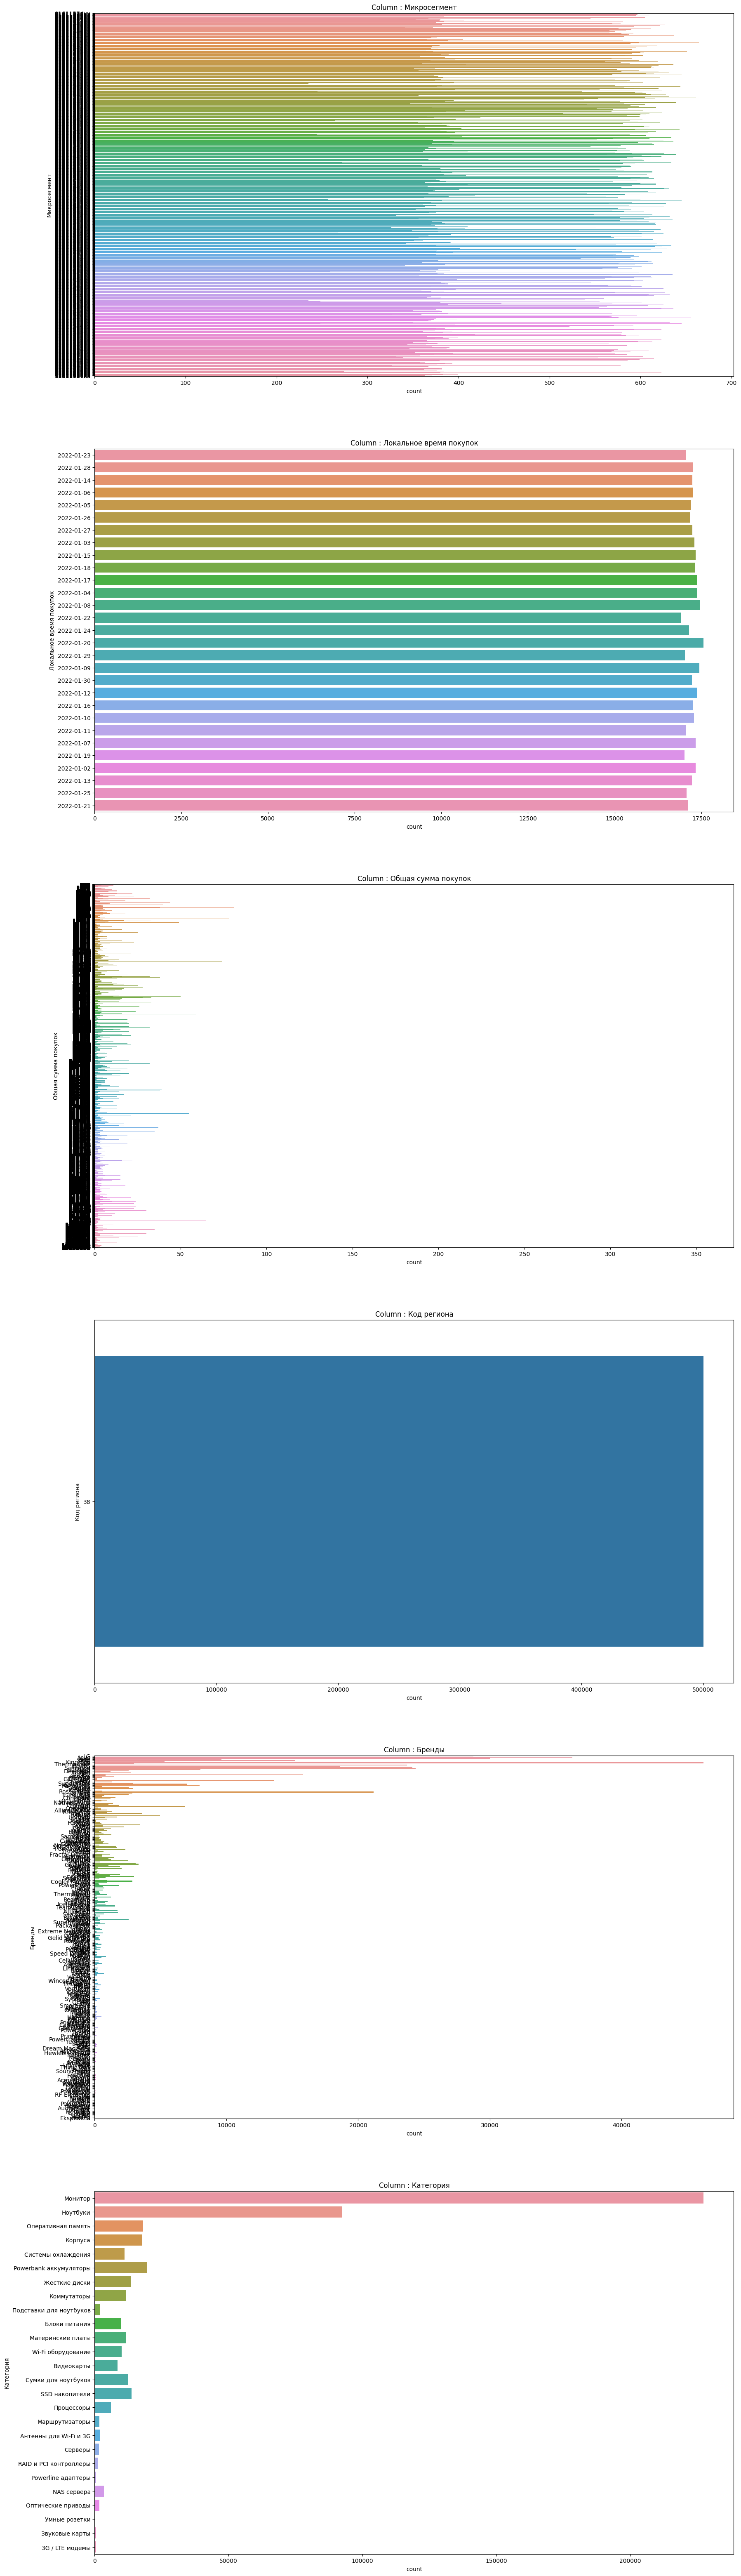

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = QI

fig, ax = plt.subplots(len(columns), figsize = (20,80))
for i in range(len(columns)):
  ax[i].set_title('Column : ' + str(columns[i]))
  sns.countplot(y = columns[i], data = df, ax = ax[i])

#### Количество повторных значений

In [10]:
def quantity_qi(arg):
    quantity = Counter(df[arg])
    dic_quan = dict(quantity)
    for idx, item in enumerate(dic_quan.items(),1):
        if(arg == 'Микросегмент'):
            ws['A' + str(idx + 1)] = f"{item[0]}=>{item[1]}шт"
            ws['A1'] = f"{arg}"
        elif(arg == 'Локальное время покупок'):
            ws['B' + str(idx + 1)] = f"{item[0]}=>{item[1]}шт"
            ws['B1'] = f"{arg}"
        elif(arg == 'Общая сумма покупок'):
            ws['C' + str(idx + 1)] = f"{item[0]}=>{item[1]}шт"
            ws['C1'] = f"{arg}"
        elif(arg == 'Код региона'):
            ws['D' + str(idx +1)] = f"{item[0]}=>{item[1]}шт"
            ws['D1'] = f"{arg}"
        elif(arg == 'Бренды'):
            ws['E' + str(idx + 1)] = f"{item[0]}=>{item[1]}шт"
            ws['E1'] = f"{arg}"
        elif(arg == 'Категория'):
            ws['F' + str(idx + 1)] = f"{item[0]}=>{item[1]}шт"
            ws['F1'] = f"{arg}"

 #### Создается Excel файл, где в каждой ячейке после стрелочки выводиться количество повторов “имени” ячейки в исходном датасете.

In [11]:
wb = Workbook()
ws = wb.create_sheet("A2")
del wb['Sheet']
for arg in QI:
    quantity_qi(arg)
wb.save('quantity.xlsx')
df2 = pd.read_excel('quantity.xlsx', sheet_name="A2", engine = 'openpyxl')
df2.head(10)

,Микросегмент,Локальное время покупок,Общая сумма покупок,Код региона,Бренды,Категория
0,91611574xx=>560шт,2022-01-23=>17045шт,406134=>24шт,38=>500000шт,LG=>28760шт,Монитор=>227224шт
1,91611870xx=>376шт,2022-01-28=>17268шт,73869=>14шт,NaN,Asus=>36271шт,Ноутбуки=>92331шт
2,91611395xx=>624шт,2022-01-14=>17241шт,32032=>22шт,NaN,Acer=>30026шт,Оперативная память=>18063шт
3,91611534xx=>597шт,2022-01-06=>17254шт,312840=>12шт,NaN,MSI=>9614шт,Корпуса=>17840шт
4,91611261xx=>596шт,2022-01-05=>17205шт,22072=>33шт,NaN,AOC=>15187шт,Системы охлаждения=>11133шт
5,91611190xx=>580шт,2022-01-26=>17175шт,25554=>6шт,NaN,Kingston=>5314шт,Powerbank аккумуляторы=>19495шт
6,91611271xx=>595шт,2022-01-27=>17244шт,79134=>34шт,NaN,HP=>46204шт,Жесткие диски=>13682шт
7,91611583xx=>610шт,2022-01-03=>17304шт,19644=>6шт,NaN,Thermaltake=>3005шт,Коммутаторы=>11763шт
8,91611932xx=>384шт,2022-01-15=>17331шт,164967=>44шт,NaN,Philips=>23717шт,Подставки для ноутбуков=>2008шт
9,91611302xx=>567шт,2022-01-18=>17318шт,75592=>57шт,NaN,Iiyama=>18607шт,Блоки питания=>9812шт
